In [25]:
from prophet import Prophet
from yahooquery import Ticker
import pandas as pd
from datetime import datetime, timedelta
import pandas_ta as ta
import plotly.express as px
import plotly.graph_objs as go
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '${:.2f}'.format

In [50]:
# Nome da ação que você deseja consultar
symbol = "WEGE3.SA"

# Calcular a data de início (2 anos atrás) e a data de fim (ontem)
end_date = datetime.now().date() - timedelta(days=1)  # Ontem
start_date = end_date - timedelta(days=365 * 4)  # quatro anos atrás

stock = Ticker(symbol)
history = stock.history(start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'), interval='1d')

In [51]:


# Reseta o índice para que a coluna de data esteja disponível
history.reset_index(level=["symbol"], inplace=True)

# Converte a coluna de data para datetime
history['date'] = pd.to_datetime(history.index)

# Define a data de ontem
yesterday = datetime.now() - timedelta(days=1)

# Filtra o DataFrame para incluir apenas dados até ontem
filtered_history = history[history['date'] < yesterday]

# Define a coluna 'date' como índice
filtered_history.set_index('date', inplace=True)

# Exibe as primeiras linhas do DataFrame filtrado
print(filtered_history.head())



              symbol   open   high    low  close    volume  adjclose  \
date                                                                   
2020-10-19  WEGE3.SA $41.51 $41.90 $40.56 $41.03  11687600    $38.56   
2020-10-20  WEGE3.SA $41.45 $41.97 $40.74 $41.78  12935000    $39.26   
2020-10-21  WEGE3.SA $43.50 $43.60 $39.15 $39.20  41216600    $36.84   
2020-10-22  WEGE3.SA $39.83 $41.34 $39.22 $41.06  26272600    $38.59   
2020-10-23  WEGE3.SA $41.12 $41.63 $40.32 $40.83  16192800    $38.38   

            dividends  splits  
date                           
2020-10-19      $0.00   $0.00  
2020-10-20      $0.00   $0.00  
2020-10-21      $0.00   $0.00  
2020-10-22      $0.00   $0.00  
2020-10-23      $0.00   $0.00  


In [52]:
display(history)

,symbol,open,high,low,close,volume,adjclose,dividends,splits,date
date,,,,,,,,,,
2020-10-19,WEGE3.SA,$41.51,$41.90,$40.56,$41.03,11687600,$38.56,$0.00,$0.00,2020-10-19
2020-10-20,WEGE3.SA,$41.45,$41.97,$40.74,$41.78,12935000,$39.26,$0.00,$0.00,2020-10-20
2020-10-21,WEGE3.SA,$43.50,$43.60,$39.15,$39.20,41216600,$36.84,$0.00,$0.00,2020-10-21
2020-10-22,WEGE3.SA,$39.83,$41.34,$39.22,$41.06,26272600,$38.59,$0.00,$0.00,2020-10-22
2020-10-23,WEGE3.SA,$41.12,$41.63,$40.32,$40.83,16192800,$38.38,$0.00,$0.00,2020-10-23
...,...,...,...,...,...,...,...,...,...,...
2024-10-09,WEGE3.SA,$53.92,$54.31,$53.29,$54.00,5806100,$54.00,$0.00,$0.00,2024-10-09
2024-10-10,WEGE3.SA,$53.70,$54.18,$53.52,$54.18,3762500,$54.18,$0.00,$0.00,2024-10-10
2024-10-11,WEGE3.SA,$54.19,$54.38,$53.63,$54.17,3283900,$54.17,$0.00,$0.00,2024-10-11


In [53]:


# Reindex data using a DatetimeIndex
history.set_index(pd.DatetimeIndex(history.index), inplace=True)

# select features that have interest to us
data = history[['date','adjclose']].copy()

# use technical analyses using 21 one days and append to our dataset
data.ta.ema(close='adjclose', length=21, append=True)

# Drop empty values
data.dropna(inplace=True)

In [54]:
#Plot
fig = px.line(data, x='date', y='adjclose')
fig.add_scatter(x=data['date'], y=data['EMA_21'], mode='lines', name='EMA 21')


fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [56]:
# Add all dataset as training model
df_train = data[['date','adjclose','EMA_21']].rename(columns={"date": "ds", "adjclose": "y"})

# Fit model
model = Prophet(daily_seasonality=True,changepoint_prior_scale=1.00)

# Train 
model.fit(df_train)

# Get dates 30 days in the future
future = model.make_future_dataframe(periods=30)

# Drop weekends
future['day'] =  future['ds'].dt.weekday
future = future[future['day'] <=4]

# Predict dates
forecast = model.predict(future)

16:47:48 - cmdstanpy - INFO - Chain [1] start processing
16:47:49 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Plot linear regression result
fig = go.Figure([
    go.Scatter(x=df_train['ds'], y=df_train['y'], name='Actual', mode='lines'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted', mode='lines'),
    go.Scatter(x=forecast['ds'], y=df_train['EMA_21'], name='EMA', mode='lines')
])

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [59]:
# Get all predictions
pred_df = forecast[forecast['ds'] > datetime.today()][['ds','yhat']]

# Reset Index
pred_df.reset_index(inplace=True)

# Drop index column
pred_df.drop(labels='index', axis=1,inplace=True)

# Rename columns
pred_df.rename(columns={'ds': 'date', 'yhat': 'predicted price'}, inplace=True)

# Show first elements
pred_df.head()

,date,predicted price
0,2024-10-18,$55.75
1,2024-10-21,$55.91
2,2024-10-22,$56.15
3,2024-10-23,$56.30
4,2024-10-24,$56.45


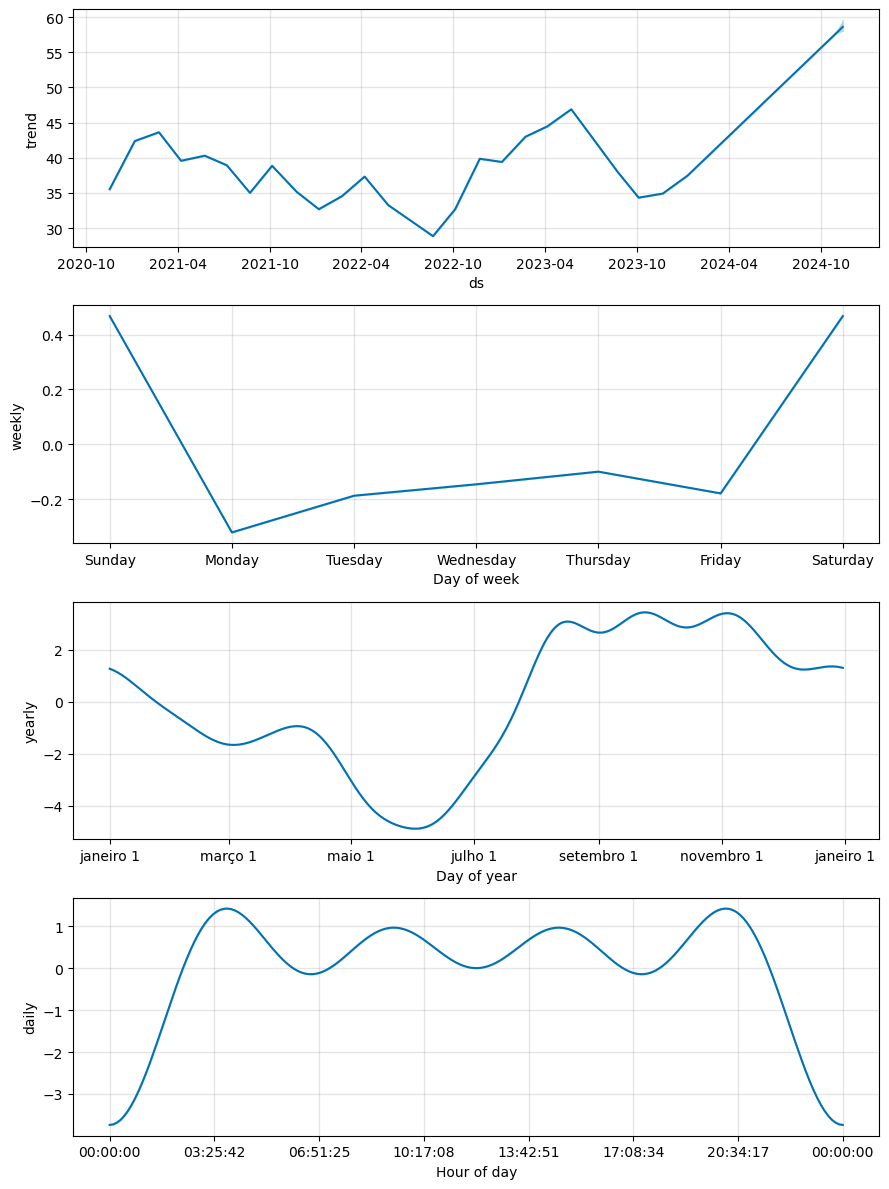

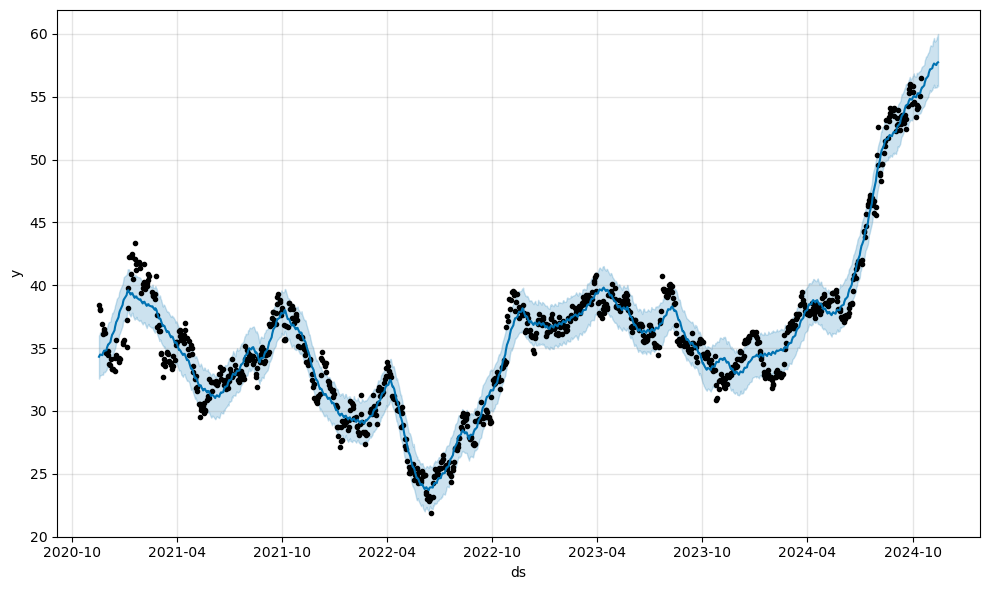

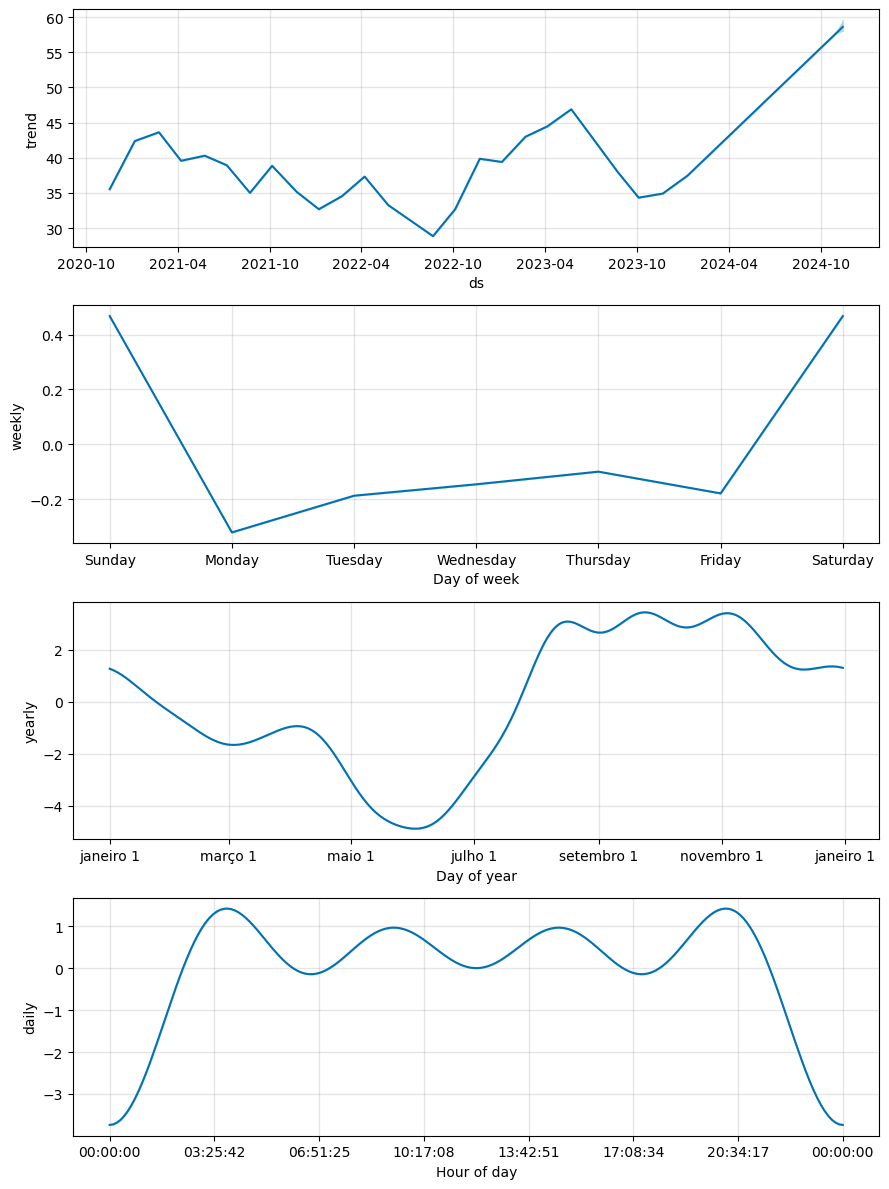

In [60]:
model.plot(forecast)
model.plot_components(forecast)

In [61]:
# execute cross validation

# reference
# https://facebook.github.io/prophet/docs/diagnostics.html#:~:text=Cross%20validation,up%20to%20that%20cutoff%20point.

df_cv = cross_validation(model, initial='720 days', period='30 days', horizon = '365 days')

# visualize data
print(df_cv.head())

# measure performance
df_p = performance_metrics(df_cv)
print(df_p.head())

  0%|          | 0/12 [00:00<?, ?it/s]

16:48:25 - cmdstanpy - INFO - Chain [1] start processing
16:48:25 - cmdstanpy - INFO - Chain [1] done processing
16:48:25 - cmdstanpy - INFO - Chain [1] start processing
16:48:26 - cmdstanpy - INFO - Chain [1] done processing
16:48:26 - cmdstanpy - INFO - Chain [1] start processing
16:48:26 - cmdstanpy - INFO - Chain [1] done processing
16:48:27 - cmdstanpy - INFO - Chain [1] start processing
16:48:27 - cmdstanpy - INFO - Chain [1] done processing
16:48:27 - cmdstanpy - INFO - Chain [1] start processing
16:48:27 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:30 - cmdstanpy - INFO - Chain [1] start processing
16:48:30 - cmdstanpy - INFO - Chain [1]

          ds   yhat  yhat_lower  yhat_upper      y     cutoff
0 2022-11-21 $38.49      $37.44      $39.43 $38.18 2022-11-20
1 2022-11-22 $38.59      $37.52      $39.62 $37.60 2022-11-20
2 2022-11-23 $38.75      $37.66      $39.77 $37.64 2022-11-20
3 2022-11-24 $38.89      $37.71      $39.98 $38.44 2022-11-20
4 2022-11-25 $38.95      $37.86      $40.01 $37.80 2022-11-20
  horizon    mse  rmse   mae  mape  mdape  smape  coverage
0 37 days $22.06 $4.70 $3.71 $0.10  $0.08  $0.10     $0.29
1 38 days $23.48 $4.85 $3.86 $0.10  $0.08  $0.10     $0.28
2 39 days $24.71 $4.97 $4.00 $0.11  $0.09  $0.11     $0.28
3 40 days $25.96 $5.09 $4.13 $0.11  $0.09  $0.11     $0.27
4 41 days $27.31 $5.23 $4.26 $0.12  $0.10  $0.11     $0.26
